In [55]:
from statsmodels.distributions.empirical_distribution import ECDF

In [1]:
from functions import *
from scipy.stats import mode
from scipy.stats import pearsonr
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
#https://www.eia.gov/electricity/data/eia923/
file_generation=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx"


#file_ext= "D:\\NASA_AIRS"
file_path_plots=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\Plots"
file_path_main=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\Generated dust_score"


dust_score_trad_hourly_mean=pd.read_csv(os.path.join(file_path_main,'dust_score_stats_CAMS49ELLIPSE_mean_hourlyTEST.csv'),index_col=0)

dust_score_inv_hourly_mean=pd.read_csv(os.path.join(file_path_main,'dust_score_stats_CAMS49ELLIPSE_mean_hourly_new.csv'),index_col=0)


#folder_year_list=sorted(os.listdir(file_ext))
file_ghi_2019=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2019.csv"
file_ghi_2020=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2020.csv"
file_ghi_2021=r"C:\Users\lehri\Documents\GitHub\dust_solar_power\NREL_NSRDB\GHI_CAMS49_2021.csv"

generation_df=pd.read_excel(file_generation, sheet_name="Page 1 Generation and Fuel Data", header=5, engine="openpyxl")

ghi_2019=pd.read_csv(file_ghi_2019, header=[2], engine="python")
ghi_2020=pd.read_csv(file_ghi_2020, header=[2], engine="python")
ghi_2021=pd.read_csv(file_ghi_2021, header=[2], engine="python")
ghi_df = pd.concat([ghi_2019, ghi_2020, ghi_2021], ignore_index=True)
ghi_df_header=pd.read_csv(file_ghi_2019, engine="python", nrows=1)
ghi_df['Datetime']= pd.to_datetime(ghi_df['Year'].astype(str) + '-' + ghi_df['Month'].astype(str) + '-' + ghi_df['Day'].astype(str) + '-' + ghi_df['Hour'].astype(str), format='%Y-%m-%d-%H')
ghi_df.set_index('Datetime', inplace=True)


In [2]:
ghi_2019_headtest=pd.read_csv(file_ghi_2019, nrows=3, engine="python")
ghi_2019_headtest.iloc[:2,24:38]

,Cloud Type -15,Cloud Type 0,Cloud Type 1,Cloud Type 2,Cloud Type 3,Cloud Type 4,Cloud Type 5,Cloud Type 6,Cloud Type 7,Cloud Type 8,Cloud Type 9,Cloud Type 10,Cloud Type 11,Cloud Type 12
0,NaN,Clear,Probably Clear,Fog,Water,Super-Cooled Water,Mixed,Opaque Ice,Cirrus,Overlapping,Overshooting,Unknown,Dust,Smoke
1,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None


In [3]:
ghi_df['Cloud Type'].value_counts()

Cloud Type
0    16695
7     3173
8     1848
1     1324
4     1255
6      926
3      885
9      101
5       97
Name: count, dtype: int64

In [4]:
'''
Clear (0): Ideal for solar power generation as no clouds block sunlight.
Low Clouds (1–3): Moderate impact on solar radiation; cumulus may cause variable shading.
Mid-Level Clouds (4–6): Can significantly diffuse sunlight and reduce direct solar radiation.
High Clouds (7–8): Minimal impact on total radiation, but may scatter light and reduce direct solar irradiance.
Deep Convective Clouds (9): Severe impact, often causing complete blockage of sunlight due to their thickness.

4,5,6,9 -> make dust_score nan for these values
'''

'\nClear (0): Ideal for solar power generation as no clouds block sunlight.\nLow Clouds (1–3): Moderate impact on solar radiation; cumulus may cause variable shading.\nMid-Level Clouds (4–6): Can significantly diffuse sunlight and reduce direct solar radiation.\nHigh Clouds (7–8): Minimal impact on total radiation, but may scatter light and reduce direct solar irradiance.\nDeep Convective Clouds (9): Severe impact, often causing complete blockage of sunlight due to their thickness.\n\n4,5,6,9 -> make dust_score nan for these values\n'

In [5]:
#get dust_score for both methods as a monthly mean and export that
cloudtypes_df=ghi_df['Cloud Type'].copy(deep=True)
dust_score_trad_hourly_mean.index=dust_score_trad_hourly_mean.index.astype("datetime64[ns]")
dust_score_inv_hourly_mean.index=dust_score_inv_hourly_mean.index.astype("datetime64[ns]")
cloud_types_all_years=[]

dust_score_trad_hourly_mean_all_years=[]
dust_score_trad_daily_mean_all_years=[]
dust_score_trad_monthly_mean_all_years=[]

dust_score_inv_hourly_mean_all_years=[]
dust_score_inv_daily_mean_all_years=[]
dust_score_inv_monthly_mean_all_years=[]
for year in [2019, 2020, 2021]:
    date_index_hourly=pd.date_range(start=f'{year}-01-01',end=f'{year+1}-01-01',freq='h')[:-1]
    if year!=2021:
        #dust_score values only until 2021-12-30, so we need to cut back one day for the NREL NSRDB data
        cloud_types_all_years.append(cloudtypes_df[f'{year}-01-01':f'{year}-12-31'])
        dust_score_flattened_trad=pd.DataFrame({'dust_score':dust_score_trad_hourly_mean[date_index_hourly[0]:date_index_hourly[-1]].values.flatten()},index=date_index_hourly)
        dust_score_flattened_inv=pd.DataFrame({'dust_score':dust_score_inv_hourly_mean[date_index_hourly[0]:date_index_hourly[-1]].values.flatten()},index=date_index_hourly)        
    else:
        cloud_types_all_years.append(cloudtypes_df[f'{year}-01-01':f'{year}-12-30'])
        dust_score_flattened_trad=pd.DataFrame({'dust_score':dust_score_trad_hourly_mean[date_index_hourly[0]:date_index_hourly[-25]].values.flatten()},index=date_index_hourly[:-24])
        dust_score_flattened_inv=pd.DataFrame({'dust_score':dust_score_inv_hourly_mean[date_index_hourly[0]:date_index_hourly[-25]].values.flatten()},index=date_index_hourly[:-24])
    dust_score_trad_hourly_mean_all_years.append(dust_score_trad_hourly_mean[f'{year}-01-01':f'{year+1}-01-01'][:-1])
    dust_score_inv_hourly_mean_all_years.append(dust_score_inv_hourly_mean[f'{year}-01-01':f'{year+1}-01-01'][:-1])

    dust_score_flattened_trad[cloud_types_all_years[year-2019]==4] = np.nan
    dust_score_flattened_trad[cloud_types_all_years[year-2019]==5] = np.nan
    dust_score_flattened_trad[cloud_types_all_years[year-2019]==6] = np.nan
    dust_score_flattened_trad[cloud_types_all_years[year-2019]==9] = np.nan

    dust_score_flattened_inv[cloud_types_all_years[year-2019]==4] = np.nan
    dust_score_flattened_inv[cloud_types_all_years[year-2019]==5] = np.nan
    dust_score_flattened_inv[cloud_types_all_years[year-2019]==6] = np.nan
    dust_score_flattened_inv[cloud_types_all_years[year-2019]==9] = np.nan
    
    dust_score_trad_daily_mean_all_years.append(dust_score_flattened_trad.resample('1D').mean())
    dust_score_trad_monthly_mean_all_years.append(dust_score_flattened_trad.resample('1ME').mean())

    dust_score_inv_daily_mean_all_years.append(dust_score_flattened_inv.resample('1D').mean())
    dust_score_inv_monthly_mean_all_years.append(dust_score_flattened_inv.resample('1ME').mean())


In [6]:
%store -r tceq_pm10_daily_mean
%store -r tceq_pm25_daily_mean

[90] 2450.9
[145] 234.0


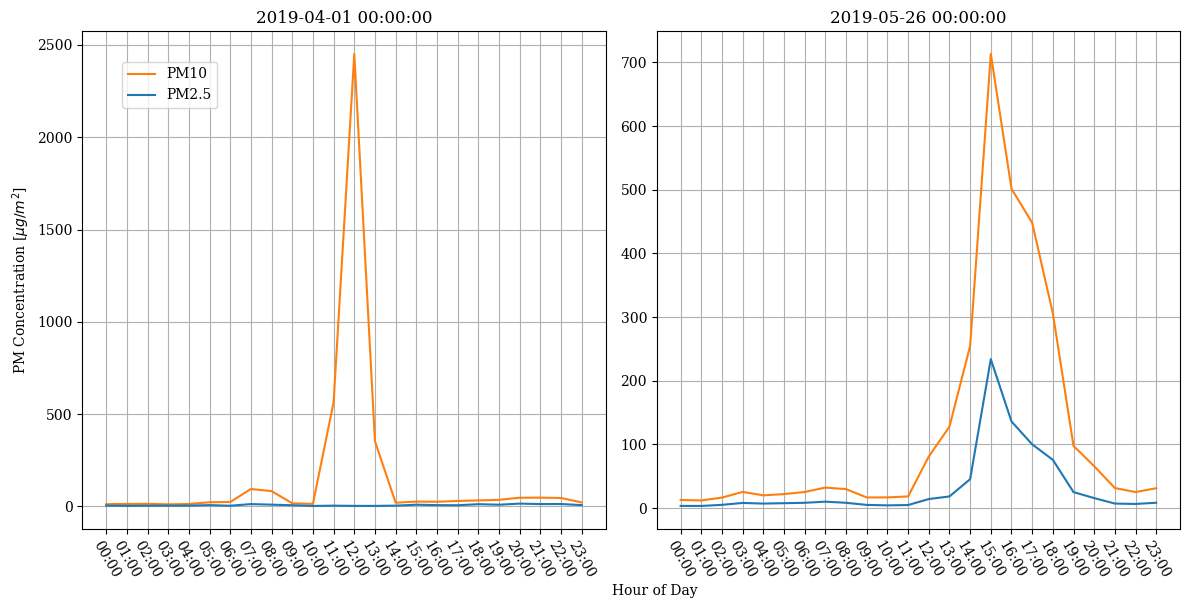

In [127]:
fig, ax=plt.subplots(1,2,figsize=(12,6))
pm_10_max_2019=np.nanmax(tceq_pm10_daily_mean[0][:-1].values.flatten())
pm_10_max_day=np.where(tceq_pm10_daily_mean[0]==pm_10_max_2019)[0]
print(pm_10_max_day, pm_10_max_2019)
day_pm10_max=tceq_pm10_daily_mean[0].iloc[pm_10_max_day,:-1].index
ax[0].set_ylabel('PM Concentration [$μg/m^2$]')
ax[0].set_title(day_pm10_max[0])
ax[0].plot(tceq_pm10_daily_mean[0].iloc[pm_10_max_day,:-1].values.flatten(),color='tab:orange')
ax[0].plot(tceq_pm25_daily_mean[0].iloc[pm_10_max_day,:-1].values.flatten(),color='tab:blue')
pm_25_max_2019=np.nanmax(tceq_pm25_daily_mean[0][:-1].values.flatten())
pm_25_max_day=np.where(tceq_pm25_daily_mean[0]==pm_25_max_2019)[0]
print(pm_25_max_day,pm_25_max_2019)
day_pm25_max=tceq_pm10_daily_mean[0].iloc[pm_25_max_day,:-1].index
ax[1].set_title(day_pm25_max[0])
ax[1].plot(tceq_pm10_daily_mean[0].iloc[pm_25_max_day,:-1].values.flatten(),label=f"PM10",color='tab:orange')
ax[1].plot(tceq_pm25_daily_mean[0].iloc[pm_25_max_day,:-1].values.flatten(), label=f"PM2.5",color='tab:blue')

ax[0].set_xticks(np.arange(24),pd.date_range(start='00:00',end='23:00',freq='h').strftime('%H:%M'),rotation=300)
ax[1].set_xticks(np.arange(24),pd.date_range(start='00:00',end='23:00',freq='h').strftime('%H:%M'),rotation=300)
fig.text(0.55, 0, 'Hour of Day', ha='center')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
ax[0].grid()
ax[1].grid()


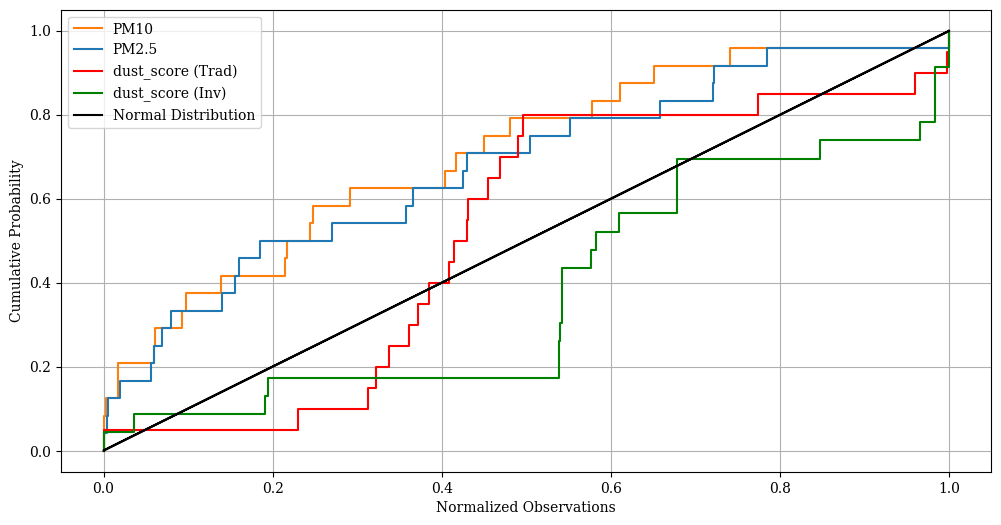

In [128]:
fig,ax=plt.subplots(figsize=(12,6))
dust_trad_norm=normalize(dust_score_trad_hourly_mean.loc['2019-04-10',:][~dust_score_trad_hourly_mean.loc['2019-04-10',:].isna()])
dust_inv_norm=normalize(dust_score_inv_hourly_mean.loc['2019-04-10',:][~dust_score_inv_hourly_mean.loc['2019-04-10',:].isna()])
tceq_cams49_pm10_norm = normalize(tceq_pm10_daily_mean[0].loc['2019-04-10',:][:-1])
tceq_cams49_pm25_norm = normalize(tceq_pm25_daily_mean[0].loc['2019-04-10',:][:-1])

ecdf1 = ECDF(tceq_cams49_pm10_norm)
ecdf2 = ECDF(tceq_cams49_pm25_norm)
ecdf3=ECDF(dust_trad_norm)
ecdf4=ECDF(dust_inv_norm)
ax.step(ecdf1.x, ecdf1.y, where='post',label='PM10',color='tab:orange')
ax.step(ecdf2.x, ecdf2.y, where='post', label='PM2.5',color='tab:blue')
ax.step(ecdf3.x, ecdf3.y, where='post', label='dust_score (Trad)',color='red')
ax.step(ecdf4.x, ecdf4.y, where='post', label='dust_score (Inv)',color='green')
x=normalize(np.linspace(0,100,1000))
ecdf_normdist = ECDF(x)
ax.step(ecdf_normdist.x, ecdf_normdist.y, where='post', label='Normal Distribution', color='black')

ax.set_ylabel("Cumulative Probability")
ax.set_xlabel("Normalized Observations")
ax.grid()
ax.legend()

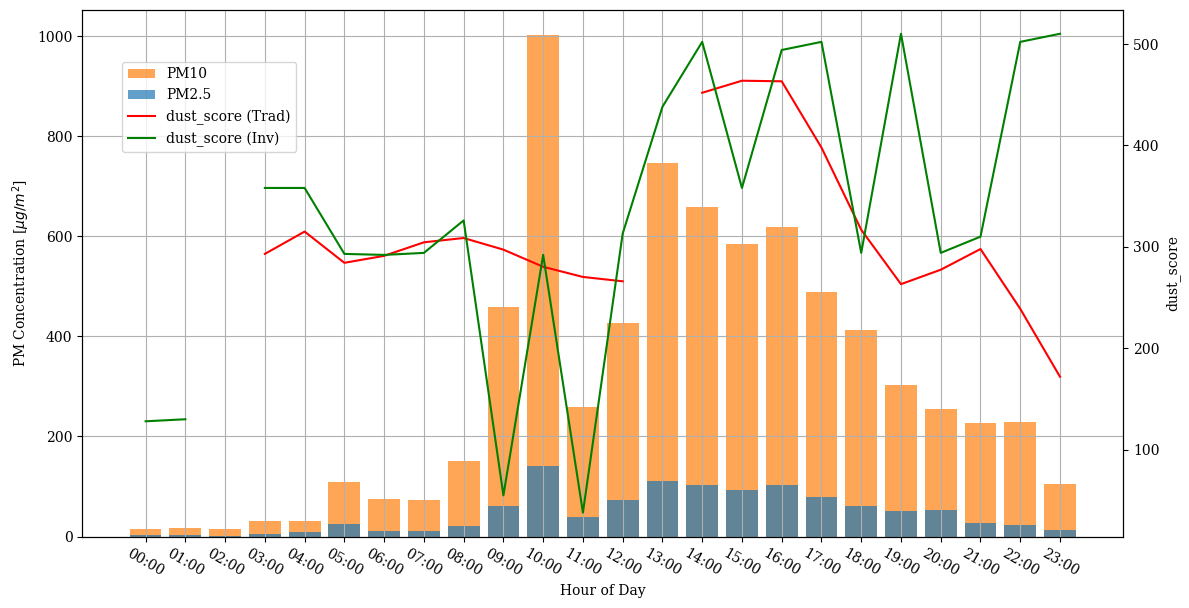

In [129]:
fig, ax= plt.subplots(figsize=(12,6))
date_index=pd.date_range(start='00:00',end='23:00',freq='h').strftime('%H:%M')
ax.set_ylabel('PM Concentration [$μg/m^2$]')
ax.set_xlabel('Hour of Day')
ax2=ax.twinx()
ax2.set_ylabel('dust_score')
ax.bar(date_index,tceq_pm10_daily_mean[0].loc['2019-04-10',:][:-1],label="PM10",color='tab:orange',alpha=0.7)
ax.bar(date_index,tceq_pm25_daily_mean[0].loc['2019-04-10',:][:-1],label="PM2.5",color='tab:blue',alpha=0.7)
ax2.plot(date_index,dust_score_trad_hourly_mean.loc['2019-04-10',:],color='red',label='dust_score (Trad)')
ax2.plot(date_index,dust_score_inv_hourly_mean.loc['2019-04-10',:],color='green',label='dust_score (Inv)')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
ax.grid()
ax.set_xticks(np.arange(24),pd.date_range(start='00:00',end='23:00',freq='h').strftime('%H:%M'),rotation=330)
plt.show()

In [54]:
print("Max PM10: ",tceq_pm10_daily_mean[0].loc['2019-04-10',:][:-1].values.max())
print("Max PM25: ",tceq_pm25_daily_mean[0].loc['2019-04-10',:][:-1].values.max())

Max PM10:  1002.8
Max PM25:  141.5


AttributeError: 'numpy.ndarray' object has no attribute 'resample'

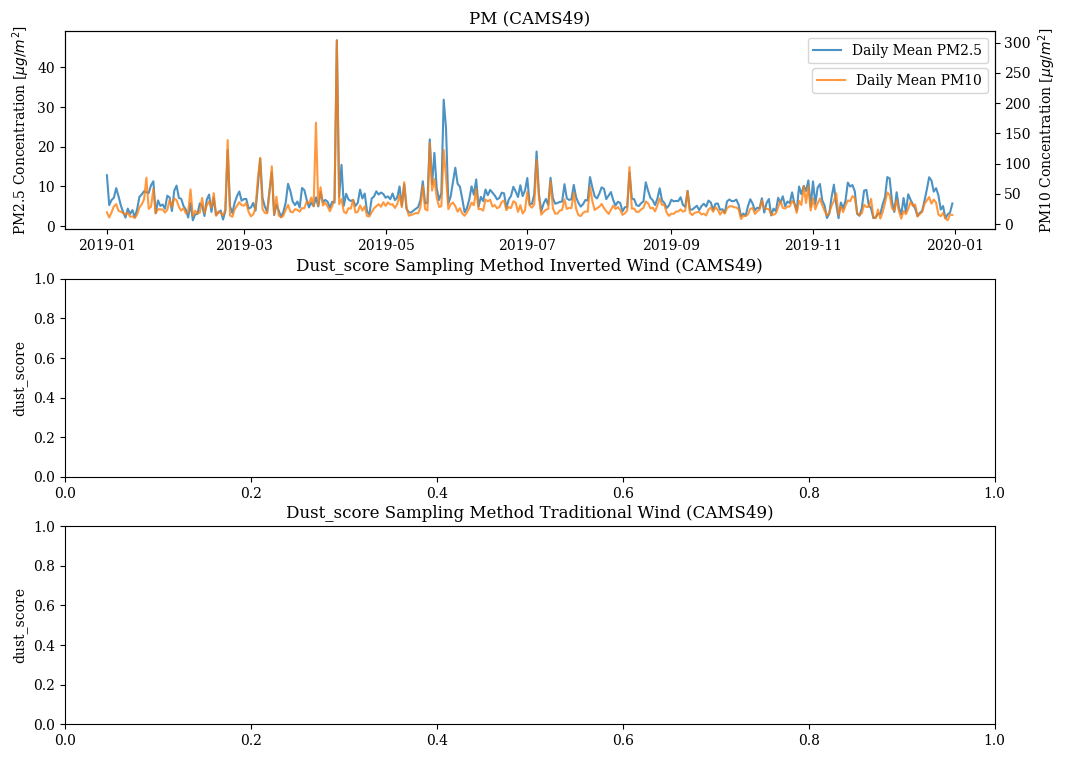

In [32]:
#these arrays will be saved in jupyter lab memory
ellipse_inv_hourly=[]
ellipse_trad_hourly=[]

scaled_dust_scores=[]
dust_scores=[]
count=0
threshold=380
file_path=r"C:/Users/lehri/Documents/GitHub/dust_solar_power/"
for year in [2019,2020,2021]:
    fig,axs=plt.subplots(3, 1,figsize=(12, 9))

    axs[0].set_title(f'PM (CAMS49)')
    axs[0].set_ylabel("PM2.5 Concentration [$μg/m^2$]")
    axs[1].set_title(f'Dust_score Sampling Method Inverted Wind (CAMS49)')
    axs[1].set_ylabel("dust_score")
    axs[2].set_title(f'Dust_score Sampling Method Traditional Wind (CAMS49)')
    axs[2].set_ylabel("dust_score")
    ax2=axs[0].twinx()
    ax2.set_ylabel("PM10 Concentration [$μg/m^2$]")
    plt.subplots_adjust(hspace=0.25)
    if year == 2021:
        date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='h')[:-25]
        date_index= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-2]
    
    else:
        date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='h')[:-1]
        date_index= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    date_index_pm= pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    date_index_hourly_pm=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='h')[:-1]
    
    file_name_cams49_p25=file_path+f'CAMS49_{year}.xlsx'
    file_name_cams49_pm10=file_path+f'CAMS49_{year}_PM10.xlsx'
    tecq_cams49_pm25=read_xlsx_tecq(file_name_cams49_p25)
    tecq_cams49_pm10=read_xlsx_tecq(file_name_cams49_pm10)
    
    annual_trad_mean=[]
    annual_inv_mean=[]

    for day in date_index:
        try:
            dust_score_trad_day=dust_score_trad_hourly_mean.loc[day.date().strftime('%Y-%m-%d')].values
            dust_score_inv_day=dust_score_inv_hourly_mean.loc[day.date().strftime('%Y-%m-%d')].values
                        
            #hourly_ellipse_mean_hourly=interpolate_gaps(hourly_ellipse_mean_hourly,2)
            #hourly_ellipse_median_hourly=interpolate_gaps(hourly_ellipse_median_hourly,2)
            #hourly_ellipse_mode_hourly=interpolate_gaps(hourly_ellipse_mode_hourly,2)
            #hourly_dust_score_circle=interpolate_gaps(hourly_dust_score_circle,1)
            #hourly_dust_score.fillna(method='ffill'hourly_dust_score, limit=1)
            #print(hourly_dust_score)
            #np.insert(annual_dust_score,[day.timetuple().tm_yday], hourly_dust_score)
            annual_trad_mean.append(dust_score_trad_day)
            annual_inv_mean.append(dust_score_inv_day)
        except KeyError as e:
            print("No data found for date: ",day)
            print("Stopping...")
            print(e)
            break
    perday_values_annual_trad=dust_score_trad_daily_mean_all_years[year-2019]
    perday_values_annual_inv=dust_score_inv_daily_mean_all_years[year-2019]
    
    
    scaled_perday_values_annual_trad=np.where(perday_values_annual_trad < threshold, perday_values_annual_trad * 0.1, perday_values_annual_trad)
    scaled_perday_values_annual_inv = np.where(perday_values_annual_inv < threshold, perday_values_annual_inv * 0.1, perday_values_annual_inv)

    #scaled_dust_scores.append(scaled_perday_values_annual_inv)
    #dust_scores.append(perday_values_annual_inv)
    #axs[0].plot(date_index_hourly_pm,tecq_cams49_pm25.values.flatten(), label='Hourly PM2.5',color='tab:blue',alpha=0.5,linestyle='dotted')
    #ax2.plot(date_index_hourly_pm,tecq_cams49_pm10.values.flatten(), label='Hourly PM10',color='tab:orange',alpha=0.5,linestyle='dotted')
    ax2.plot(date_index_pm,tceq_pm10_daily_mean[year-2019]['Daily'].values.flatten(), label='Daily Mean PM10',color='tab:orange',alpha=0.8)
    axs[0].plot(date_index_pm,tceq_pm25_daily_mean[year-2019]['Daily'].values.flatten(), label='Daily Mean PM2.5',color='tab:blue',alpha=0.8)
    axs[0].legend(loc='upper right')
    ax2.legend(loc='upper right',bbox_to_anchor=(1,0.85))

    axs[1].plot(date_index_hourly, scaled_perday_values_annual_inv.flatten(), label='Hourly Mean',color='red',alpha=0.5)
    axs[1].plot(date_index, dust_score_inv_daily_mean_all_years[year-2019].values.flatten(), label='Daily Mean',color='green',alpha=0.5)
    axs[1].legend(loc='upper right')
    
    axs[2].plot(date_index_hourly, scaled_perday_values_annual_trad.flatten(), label='Hourly Mean',color='red',alpha=0.5)
    axs[2].plot(date_index,dust_score_trad_daily_mean_all_years[year-2019].values.flatten(), label='Daily Mean',color='green',alpha=0.5)
    axs[2].legend(loc='upper right')

    ellipse_inv_mean_hourly_nonan=perday_values_annual_inv[~np.isnan(perday_values_annual_inv)]
    ellipse_trad_mean_hourly_nonan=perday_values_annual_trad[~np.isnan(perday_values_annual_trad)]
    ellipse_inv_hourly.append(ellipse_inv_mean_hourly_nonan)
    ellipse_trad_hourly.append(ellipse_trad_mean_hourly_nonan)
    print("Stats for ",year)
    print("Inverted Wind Method")
    print(f"N Total {dust_score_inv_nocloud[year-2019].size}, and N noNaN {ellipse_inv_mean_hourly_nonan.size}")
    print(f"N Unique {np.unique(dust_score_inv_nocloud[year-2019]).size}")
    print("Trad Wind Method")
    print(f"N Total {dust_score_trad_nocloud[year-2019].size}, and N noNaN {ellipse_trad_mean_hourly_nonan.size}")
    print(f"N Unique {np.unique(dust_score_trad_nocloud[year-2019]).size}")

In [ ]:
%store dust_score_trad_nocloud
%store dust_score_inv_nocloud
%store dust_score_trad_monthly_mean_all_years
%store dust_score_inv_monthly_mean_all_years
%store dust_score_trad_daily_mean_all_years
%store dust_score_inv_daily_mean_all_years

In [ ]:
%store ellipse_inv_hourly
%store ellipse_trad_hourly

In [ ]:
count=0
#kwargs = {'drawstyle' : 'steps'}
for year in [2019,2020,2021]:
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)

    #file_name_cams49_pm10=f'CAMS49_2019_PM10.xlsx'
    #tecq_cams49_pm10=read_xlsx_tecq(file_name_cams49_pm10)
    #print(tecq_cams49_pm10)
    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    print(date_index_hourly.shape)
    date_index_daily=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    fig,axs=plt.subplots(3, 1,figsize=(18, 9))
    #plt.subplots_adjust(hspace=0.5)
    axs[0].set_title(f'{year} Hourly PM2.5, GHI, and dust_score at CAMS49')
    axs[0].set_ylabel("PM2.5 (μg/m3)")
    #axs[1].set_title(f'2019 Hourly GHI at CAMS49')
    axs[1].set_ylabel("GHI (W/m2)")
    axs[2].set_ylabel("dust_score")
    #axs[3].set_ylabel("wind speed (mph)")
    
    #axs[0].plot(date_index_hourly, tecq_cams49.values.flatten(), label='Hourly PM',alpha=0.5)
    axs[0].plot(date_index_daily, np.nanmean(tecq_cams49.values,axis=1), label='Daily Mean PM2.5',color='blue',alpha=0.5)
    #axs[0].plot(date_index_daily, np.nanmean(tecq_cams49_pm10.values,axis=1), label='Daily Mean PM10',color='green',alpha=0.5)

    axs[0].legend()
    
    #axs[1].plot(date_index_hourly, ghi_df['DNI'], label='Hourly DNI',color='red',alpha=0.5)
    #not that ghi['GHI'][f'{year}-01-01':f'{year}-12-31'] means that the upper limit will be {year}-12-31 00:00:00 hence the 31st will be included
    axs[1].plot(date_index_hourly, ghi_df['GHI'][f'{year}-01-01':f'{year}-12-31'], label='Hourly GHI',color='blue',alpha=0.5)
    
    
    ax2 = axs[1].twinx()
    ax2.plot(date_index_daily, energy_generation_plant[count], label='Solar Energy Generation',color='red',alpha=0.5)
    ax2.set_ylabel('Daily Generation (MWh)')
    # Display legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = axs[1].get_legend_handles_labels()
    axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
    axs[2].plot(date_index_hourly, scaled_dust_scores[count].flatten(), label='Hourly Mean (scaled down)',color='red',alpha=0.5)
    axs[2].plot(date_index_daily, np.nanmean(dust_scores[count],axis=1), label='Daily Mean',color='green')
    #axs[2].set_yscale('log')
    axs[2].legend(loc='upper right')

    #axs[3].plot(date_index_hourly, ghi_df['Wind Speed'][f'{year}-01-01':f'{year}-12-31'], label='Hourly',alpha=0.5)
    #axs[3].plot(date_index_daily, windspd_year_mean[count], label='Daily Mean',color='green',alpha=0.75)
    #axs[3].plot(date_index_daily, windspd_year_median[count], label='Daily Median wind speed',color='red',alpha=0.75)
    #axs[3].plot(date_index_daily, windspd_year_mode[count], label='Daily Mode wind speed',color='blue',alpha=0.75)

    #axs[3].legend(loc='upper right')

    
    #print(len(ghi_df['DNI']), len(tecq_cams49.values))
    #corr_coefficient, p_value = pearsonr( sun_hours_year[count], np.nanmean(tecq_cams49.values[:-np.abs((len(date_index_daily)-len(sun_hours_year[count])))],axis=1))
    corr_coefficient, p_value = pearsonr(ghi_df['GHI'][f'{year}-01-01':f'{year}-12-31'], tecq_cams49.interpolate().values.flatten())
    corr_coefficient_wind_dust, p_value_wind_dust = pearsonr(ghi_df['Wind Speed'][f'{year}-01-01':f'{year}-12-31'], tecq_cams49.interpolate().values.flatten())
    print(corr_coefficient, p_value )
    print(corr_coefficient_wind_dust, p_value_wind_dust )
    count+=1

In [ ]:
#Generation per year
for year in [0,1,2]:
    net_gen=sum(num_peak_sun_hours_year_daily[year]*Wp/1000*panel_yield*number_of_panels*PR)
    print("Generated energy (kWh): ",net_gen)
    print("Number of households: ", net_gen/south_household_consumption_2023)

In [ ]:
count=0
for year in [2019]:
    
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    fig,ax=plt.subplots(1, 1,figsize=(10, 5))
    #plt.subplots_adjust(hspace=0.5)
    ax.set_title(f'{year} Texas Solar Generation Comparison')
    ax.set_ylabel("Monthly Generation (MWh)")
    
    ax.plot(date_index_monthly, num_peak_sun_hours_year_daily[count]*Wp/1000*panel_yield*number_of_panels*PR/1000, label='Buena Vista 120MW (modeled) (MWh)',color='red',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_newman_elpaso.values, label='Newman 10MW (actual) (MWh)',color='green',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_montana_elpaso.values, label='Montana 3MW (actual) (MWh)',color='blue',alpha=0.5)
    ax.plot(date_index_monthly, elec_gen_2019_uptoncounty.values, label='Upton County 180MW (actual) (MWh)',color='orange',alpha=0.5)
    ax.legend(loc='upper right')

In [ ]:
count=0
for year in [2019,2020,2021]:
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)
    date_index_hourly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='H')[:-1]
    date_index_monthly = pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='M')
    date_index_daily=pd.date_range(start=f'{year}-01-01', end=f'{year+1}-01-01', freq='D')[:-1]
    fig,axs=plt.subplots(2, 1,figsize=(18, 4))
    #plt.subplots_adjust(hspace=0.5)
    axs[0].set_title(f'{year} Daily PM2.5 and wind speed at CAMS49')
    axs[0].set_ylabel("PM2.5 (μg/m3)")
    axs[1].set_ylabel('wind speed (mph)')
    
    axs[0].plot(date_index_daily, np.nanmean(tecq_cams49.values,axis=1), label='Daily Mean PM',color='blue',alpha=0.5)
    axs[0].legend(loc='upper right')
        
    axs[1].plot(date_index_daily, windspd_year_mean[count], label='Daily Mean',color='green',alpha=0.75)   
    
    axs[1].legend(loc='upper right')
    count+=1


In [ ]:
def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan

    return filled

##TO DO##
#interpolate with KNN instead